<a href="https://colab.research.google.com/github/leticiasdrummond/Modelos-Base/blob/main/1_2_CASO_BASE_Modificado_ELETROPOSTO_11_02_26.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pré-básico
Para utilizar o gurobi e o pymo, executar abaixo:

In [ ]:
# ========================
# CÉLULA 1: INSTALAR
# ========================
!pip install gurobipy

# COLE SEU TOKEN AQUI ⬇️
MEU_TOKEN = "2751719"

import gurobipy as gp

# ========================
m = gp.Model()
# Conectar à licença web
env = gp.Env()
env.start()
print("✅ Licença ativada via WLS!")

# ============================================================
# Instalação de dependências
# ============================================================
!pip install pyomo
!apt-get install -y glpk-utils

## A. Importação
from pyomo.environ import *
# Instalação (apenas se necessário no Colab)
!apt-get install -y coinor-cbc
# !pip install pyomo

import pyomo.environ as pyo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Restricted license - for non-production use only - expires 2027-11-29
✅ Licença ativada via WLS!
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
glpk-utils is already the newest version (5.0-1).
0 upgraded, 0 newly installed, 0 to remove and 2 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
coinor-cbc is already the newest version (2.10.7+ds1-1).
0 upgraded, 0 newly installed, 0 to remove and 2 not upgraded.



# MODELO Caso Base com parametros revisados – OTIMIZAÇÃO DE BESS EM COMÉRCIO COM ELETROPOSTO
## MILP – Pyomo – Pronto para Google Colab

Curvas de demanda do comércio e eletroposto (separados) criados com dados exemplificados para 24 horas, bem como a curva de geração FV para o mesmo período. Os dados de capacidade e eficiencia da bateria também são fornecidos. A tarifa de compra e venda de energia também são dadas.
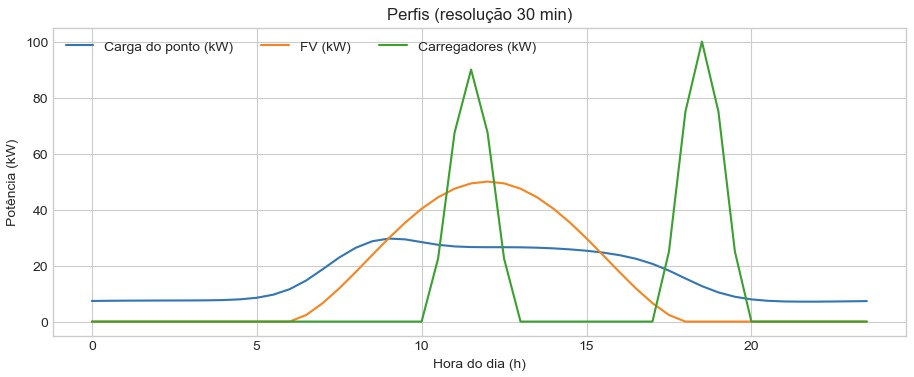

#  1. DADOS DE ENTRADA (EXEMPLO FACTÍVEL e Próximo a Imagem Molde)

# Notas de Revisão Caso Base 1 e Evolução para Caso Base 1.2
Com base na análise do código extraído do arquivo `1 CASO BASE - ELETROPOSTO 11/02/26.ipynb` e na comparação com as anotações manuscritas (imagens) e as notas de texto da reunião, preparei este comparativo detalhado.

O Colab representa a **implementação do "Caso Base" pós-reunião**, validando a lógica física, enquanto as notas e imagens representam o **Roteiro de Evolução** para os próximos cenários (Peak Shaving e Grupo A).

### 1. O que é Equivalente (Implementado no Colab)

Estes pontos confirmam que o código reflete as discussões iniciais da reunião e as premissas físicas das imagens.

 **A. "Restrição do Guilherme" (Continuidade):**
* **No Colab:** A linha de código `model.soc_amanha = pyo.Constraint(expr= model.SOC[23] >= soc_inicial)` está presente exatamente como descrito nas notas de texto (referida como "linha 93").
* **Nas Notas:** Foi solicitada para garantir que o BESS não termine o dia vazio, viabilizando a operação contínua.


**B. Lógica de Eficiência (η):**
* **No Colab:** O balanço de massa da bateria usa `eta_c = 0.955` multiplicando na carga e `1/eta_d` na descarga.
* **Nas Imagens (Img 2):** Havia o rascunho dessa lógica (multiplicar na entrada, dividir na saída) para penalizar as perdas. Isso explica o resultado econômico observado onde "carregar da rede é mais caro".


**C. Energia Inicial (Eini):**
* **No Colab:** `soc_inicial` é definido como 50% de 50kWh = **25 kWh**.
* **Nas Imagens (Img 3):** Há uma anotação explícita de "Eini = 25kW 1h".


**D. Topologia do Sistema:**
* O código inclui vetores para `demanda_ev`, `demanda_comercio`, `geracao_pv` e `P_grid`, respeitando o diagrama de barramento desenhado na **Imagem 1**.



In [ ]:

# =========================================================

T = range(24) # horizonte horário
'''
# =========================================================
# Caso Base - 1 : Verificado com o Gui em 11/02/2026
# =========================================================

# Demanda do comércio (kWh)
demanda_comercio = [
    6, 6, 6, 6, 7, 8, 10, 12, 14, 15, 16, 17,
    18, 18, 17, 16, 15, 14, 12, 10, 9, 8, 7, 6
]

# Demanda do eletroposto (kWh)
demanda_ev = [
    0, 0, 0, 0, 0, 0,
    5, 8, 10, 6, 4, 2,
    0, 0, 0, 2, 4, 6,
    8, 6, 4, 2, 0, 0
]

# Geração fotovoltaica (kWh)
geracao_pv = [
    0, 0, 0, 0, 0, 0,
    2, 5, 8, 12, 15, 18,
    20, 18, 15, 10, 6, 3,
    1, 0, 0, 0, 0, 0
]
'''
# ============================================================
# DADOS DE ENTRADA CORRIGIDOS (24 HORAS)
# ============================================================

# Demanda do comércio (kW)
# Ajustado para que a soma seja 720 (Média exata = 30 kW)
demanda_comercio = [
    5, 5, 5, 5, 5, 8,            # 00h - 05h (Madrugada baixa)
    12, 25, 40, 50, 60, 65,      # 06h - 11h (Subida manhã)
    65, 60, 55, 50, 45, 40,      # 12h - 17h (Tarde alta)
    35, 30, 25, 15, 10, 5        # 18h - 23h (Descida noite)
]

# Demanda do eletroposto (kW)
# Considera 2 carregadores de 50kW (Max 100kW) com dois picos de uso
demanda_ev = [
    0, 0, 0, 0, 0, 0,            # 00h - 05h
    10, 40, 80, 95, 70, 40,      # 06h - 11h (Pico Manhã ~09h)
    20, 20, 30, 50, 80, 100,     # 12h - 17h (Carga leve tarde -> Início Pico)
    90, 60, 30, 10, 0, 0         # 18h - 23h (Pico Noite ~18h e fim)
]

# Geração fotovoltaica (kW)
# Compatível com sistema de 50 kWp (Pico ao meio-dia)
geracao_pv = [
    0, 0, 0, 0, 0, 0,            # 00h - 05h (Sem sol)
    2, 12, 28, 42, 48, 50,       # 06h - 11h (Amanhecer até pico)
    50, 48, 42, 28, 12, 2,       # 12h - 17h (Pico até anoitecer)
    0, 0, 0, 0, 0, 0             # 18h - 23h (Sem sol)
]

# Custos (R$/kWh)
custo_compra = 0.75
preco_venda = 0.40

# Parâmetros da bateria
capacidade_bess = 50.0      # kWh
potencia_max_bess = 15.0    # kW
soc_min = 0.20 * capacidade_bess
soc_max = 0.95 * capacidade_bess
soc_inicial = 0.50 * capacidade_bess


eta_c = 0.955  # eficiência de carga
eta_d = 0.955  # eficiência de descarga

# Custo de degradação (R$/kWh throughput)
custo_degradacao = 0.08

In [ ]:
# =========================================================
# 2. CRIAÇÃO DO MODELO
# =========================================================

model = pyo.ConcreteModel()

model.T = pyo.Set(initialize=T)

# =========================================================
# 3. VARIÁVEIS DE DECISÃO
# =========================================================

model.P_grid = pyo.Var(model.T, domain=pyo.NonNegativeReals)        # compra da rede
model.P_export = pyo.Var(model.T, domain=pyo.NonNegativeReals)      # venda à rede

model.P_charge = pyo.Var(model.T, domain=pyo.NonNegativeReals)      # carga da bateria
model.P_discharge = pyo.Var(model.T, domain=pyo.NonNegativeReals)  # descarga da bateria

model.SOC = pyo.Var(model.T, domain=pyo.NonNegativeReals)

# Variáveis binárias (bloqueio simultâneo)
model.u_charge = pyo.Var(model.T, domain=pyo.Binary)
model.u_discharge = pyo.Var(model.T, domain=pyo.Binary)

# =========================================================
# 4. FUNÇÃO OBJETIVO
# =========================================================

def objective_rule(m):
    custo_energia = sum(custo_compra * m.P_grid[t] for t in m.T)
    receita_venda = sum(preco_venda * m.P_export[t] for t in m.T)
    custo_deg = sum(
        custo_degradacao * (m.P_charge[t] + m.P_discharge[t])
        for t in m.T
    )
    return custo_energia + custo_deg - receita_venda

model.OBJ = pyo.Objective(rule=objective_rule, sense=pyo.minimize)

# =========================================================
# 5. RESTRIÇÕES
# =========================================================

# 5.1 Balanço de energia
def energy_balance_rule(m, t):
    demanda_total = demanda_comercio[t] + demanda_ev[t]
    return (
        m.P_grid[t]
        + geracao_pv[t]
        + m.P_discharge[t]
        ==
        demanda_total
        + m.P_charge[t]
        + m.P_export[t]
    )

model.energy_balance = pyo.Constraint(model.T, rule=energy_balance_rule)


# Implementação da Restrição 4.2: Dinâmica do SOC, com perdas explicitadas
def soc_rule(m, t):
    # Losses associated with charging
    charge_losses_kW = (1 - eta_c) * m.P_charge[t]
    # Losses associated with discharging
    # Power drawn from storage is P_discharge / eta_d
    # So discharge losses are (P_discharge / eta_d) - P_discharge
    discharge_losses_kW = (1/eta_d - 1) * m.P_discharge[t]

    # Net change in SOC = (Energy_Charged_Gross - Charge_Losses) - (Energy_Discharged_Gross + Discharge_Losses)
    # This is equivalent to: (eta_c * P_charge) - (P_discharge / eta_d)

    if t == 0:
        # SOC[t] = soc_inicial + RECARGA_BRUTA - PERDAS_CARGA - (DESCARGA_BRUTA + PERDAS_DESCARGA)
        return m.SOC[t] == soc_inicial + (m.P_charge[t] - charge_losses_kW) - (m.P_discharge[t] + discharge_losses_kW)

    # SOC[t] = SOC[t-1] + RECARGA_BRUTA - PERDAS_CARGA - (DESCARGA_BRUTA + PERDAS_DESCARGA)
    return m.SOC[t] == m.SOC[t-1] + (m.P_charge[t] - charge_losses_kW) - (m.P_discharge[t] + discharge_losses_kW)

# Reatribuindo (ou criando, se não existisse) a restrição soc_dyn no modelo
# O Pyomo pode emitir um WARNING se a restrição já existir, indicando que ela está sendo substituída.
model.soc_dyn = pyo.Constraint(model.T, rule=soc_rule)
# 5.3 Limites de SOC
model.soc_min = pyo.Constraint(model.T, rule=lambda m, t: m.SOC[t] >= soc_min)
model.soc_max = pyo.Constraint(model.T, rule=lambda m, t: m.SOC[t] <= soc_max)
model.soc_amanha = pyo.Constraint(expr= model.SOC[23] >= soc_inicial) #incluido junto do Guilherme para garantir que o BESS esteja minimamente carregado no final das 24h
# 5.4 Limites de potência com binárias
model.charge_limit = pyo.Constraint(
    model.T, rule=lambda m, t: m.P_charge[t] <= potencia_max_bess * m.u_charge[t]
)

model.discharge_limit = pyo.Constraint(
    model.T, rule=lambda m, t: m.P_discharge[t] <= potencia_max_bess * m.u_discharge[t]
)

# 5.5 Bloqueio de carga e descarga simultâneas
model.no_simultaneous = pyo.Constraint(
    model.T, rule=lambda m, t: m.u_charge[t] + m.u_discharge[t] <= 1
)



# =========================================================
# 6. RESOLUÇÃO
# =========================================================

solver = pyo.SolverFactory("cbc")
results = solver.solve(model, tee=False)

# =========================================================
# 7. RESULTADOS
# =========================================================

# Define column names explicitly to avoid hidden character issues
col_demanda_comercio = "Demanda_Comercio".strip()
col_demanda_ev = "Demanda_EV".strip()
col_pv = "PV".strip()
col_grid = "Grid".strip()
col_export = "Export".strip()
col_carga_bess = "Carga_BESS".strip()
col_descarga_bess = "Descarga_BESS".strip()
col_soc = "SOC".strip()
col_hora = "Hora".strip()

df = pd.DataFrame({
    col_hora: list(T),
    col_demanda_comercio: demanda_comercio,
    col_demanda_ev: demanda_ev,
    col_pv: geracao_pv,
    col_grid: [pyo.value(model.P_grid[t]) for t in T],
    col_export: [pyo.value(model.P_export[t]) for t in T],
    col_carga_bess: [pyo.value(model.P_charge[t]) for t in T],
    col_descarga_bess: [pyo.value(model.P_discharge[t]) for t in T],
    col_soc: [pyo.value(model.SOC[t]) for t in T]
})

print(df)
print("Custo total (R$):", pyo.value(model.OBJ))

print(f"Valor da Função Objetivo (Custo Total): R$ {pyo.value(model.OBJ):.2f}")

    Hora  Demanda_Comercio  Demanda_EV  PV   Grid  Export  Carga_BESS  \
0      0                 5           0   0    5.0     0.0         0.0   
1      1                 5           0   0    5.0     0.0         0.0   
2      2                 5           0   0    5.0     0.0         0.0   
3      3                 5           0   0    5.0     0.0         0.0   
4      4                 5           0   0    5.0     0.0         0.0   
5      5                 8           0   0    8.0     0.0         0.0   
6      6                12          10   2   20.0     0.0         0.0   
7      7                25          40  12   53.0     0.0         0.0   
8      8                40          80  28   92.0     0.0         0.0   
9      9                50          95  42  103.0     0.0         0.0   
10    10                60          70  48   82.0     0.0         0.0   
11    11                65          40  50   55.0     0.0         0.0   
12    12                65          20  50   35.0  

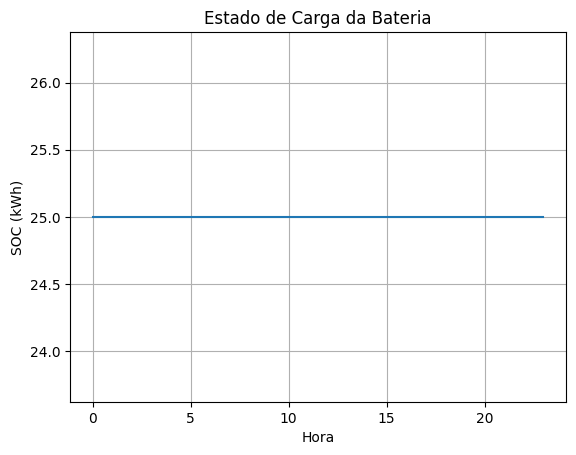

In [ ]:

# =========================================================
# 8. GRÁFICOS
# =========================================================

plt.figure()
plt.plot(df[col_hora], df[col_soc])
plt.xlabel("Hora")
plt.ylabel("SOC (kWh)")
plt.title("Estado de Carga da Bateria")
plt.grid()
plt.show()

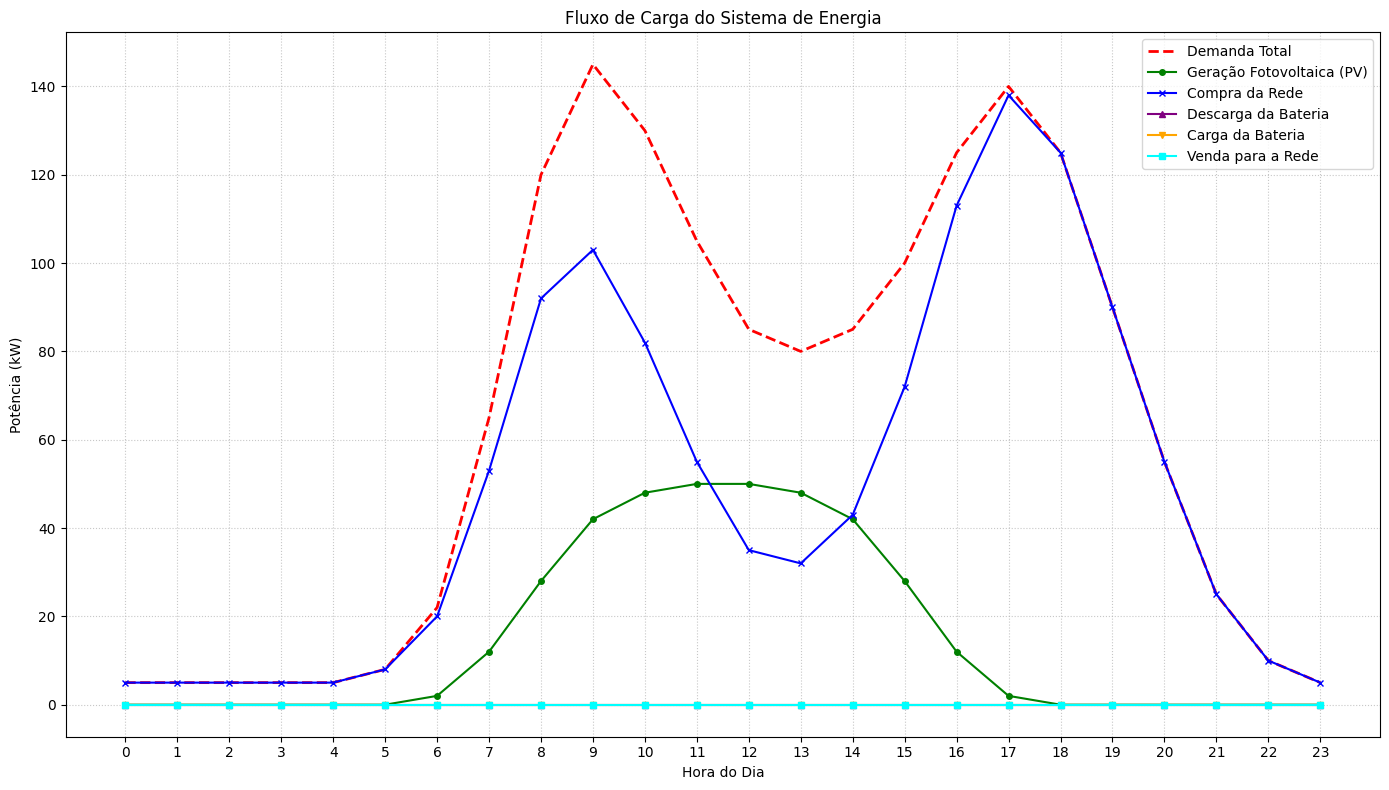

In [ ]:
# Define column names explicitly to avoid hidden character issues
col_demanda_comercio = "Demanda_Comercio".strip()
col_demanda_ev = "Demanda_EV".strip()
col_pv = "PV".strip()
col_grid = "Grid".strip()
col_export = "Export".strip()
col_carga_bess = "Carga_BESS".strip()
col_descarga_bess = "Descarga_BESS".strip()
col_soc = "SOC".strip()
col_hora = "Hora".strip()

plt.figure(figsize=(14, 8))

# Plotando a demanda total
df['Demanda_Total'] = df[col_demanda_comercio] + df[col_demanda_ev]
plt.plot(df[col_hora], df['Demanda_Total'], label='Demanda Total', color='red', linestyle='--', linewidth=2)

# Plotando as fontes de energia
plt.plot(df[col_hora], df[col_pv], label='Geração Fotovoltaica (PV)', color='green', marker='o', markersize=4)
plt.plot(df[col_hora], df[col_grid], label='Compra da Rede', color='blue', marker='x', markersize=4)
plt.plot(df[col_hora], df[col_descarga_bess], label='Descarga da Bateria', color='purple', marker='^', markersize=4)
plt.plot(df[col_hora], df[col_carga_bess], label='Carga da Bateria', color='orange', marker='v', markersize=4)
plt.plot(df[col_hora], df[col_export], label='Venda para a Rede', color='cyan', marker='s', markersize=4)

plt.xlabel('Hora do Dia')
plt.ylabel('Potência (kW)')
plt.title('Fluxo de Carga do Sistema de Energia')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.xticks(df[col_hora])
plt.tight_layout()
plt.show()


---

### 2. Principais Diferenças (O que falta implementar)

As diferenças abaixo não são erros, mas sim "lacunas" entre o modelo base simplificado (atual) e o modelo avançado solicitado nas anotações.
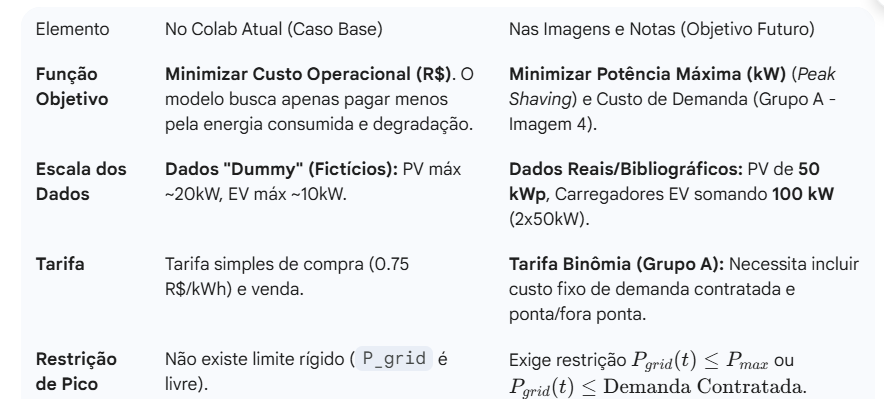

---

### 3. Análise da Lógica e Resultados

**Por que considerar essas diferenças?**

1. **Validação da Premissa Econômica (Notas de Texto):**
* As notas dizem: *"A compra de energia elétrica da rede... para carregar o BESS... fica mais cara que comprar energia elétrica para atender diretamente a carga."*
* **Reconhecimento no Colab:** O código atual comprova isso. Como a Função Objetivo minimiza custos e existem perdas (`eta_c` e `eta_d`), o modelo matemático "percebe" que é prejuízo comprar energia (perder 5% na entrada + 5% na saída) para usar depois. Por isso, ele **só carrega com excedente solar** (que tem custo marginal zero), exatamente como relatado nas notas.


2. **Estratégia de Desenvolvimento:**
* O Colab cumpre o papel de **"Caso Base"**: Garante que o balanço de energia funciona e que o BESS não viola limites físicos.
* Agora, para atingir o objetivo das imagens (reduzir demanda de pico dos carregadores de 100kW), você precisa alterar a **Função Objetivo** e os **Dados de Entrada** conforme o *Cenário 2* que estruturei na resposta anterior.



### Resumo para o Relatório

Ao passar isso a limpo, você pode afirmar que:

> *"O código atual (`Caso Base`) já incorpora a lógica física de eficiência e continuidade temporal solicitada na reunião de 11/02. A próxima etapa consiste apenas em alterar a função objetivo de 'Minimização de Custo' para 'Peak Shaving' e atualizar os vetores de carga para refletir o cenário de alta potência (100kW) dos veículos elétricos."*

Este gráfico mostra os fluxos de potência de cada componente do sistema ao longo das 24 horas. Você pode observar:

*   **Demanda Total (linha vermelha tracejada)**: A soma da demanda do comércio e do eletroposto.
*   **Geração Fotovoltaica (linha verde)**: A produção de energia solar, que é maior durante o dia.
*   **Compra da Rede (linha azul)**: A energia que o sistema precisa comprar da concessionária para cobrir o déficit.
*   **Descarga da Bateria (linha roxa)**: Quando a bateria está fornecendo energia para o sistema.
*   **Carga da Bateria (linha laranja)**: Quando a bateria está sendo carregada.
*   **Venda para a Rede (linha ciano)**: Excedente de energia sendo exportado para a rede.

Com este gráfico, é possível analisar o balanço energético do sistema, como a bateria e a geração fotovoltaica atuam para suprir a demanda e interagem com a rede elétrica.



---

# Treinamento

equema sistema de energia do pequeno comércio com geração fotovoltaica, banco de baterias e eletroposto. O conteúdo está dividido em seções claras, com tabelas, fluxos e dimensionamento elétrico.

---

## 🔧 Esquema Técnico: Sistema de Energia para Pequeno Comércio com FV, BESS e Eletroposto

## 1. 📦 Equipamentos do Sistema

| Equipamento         | Descrição                                                                 | Potência Nominal | Capacidade Energética | Tensão | Corrente Máxima |
|---------------------|---------------------------------------------------------------------------|------------------|------------------------|--------|------------------|
| Painéis FV          | Sistema fotovoltaico de 10 kWp, geração distribuída                       | 10 kW            | —                      | 220 V  | 45,5 A           |
| Banco de Baterias   | Armazenamento de energia (BESS) com controle de carga e descarga          | 5 kW             | 20 kWh                 | 220 V  | 22,7 A           |
| Eletroposto         | Carregador de veículo elétrico (1 ponto)                                  | 7 kW             | —                      | 220 V  | 31,8 A           |
| Carga do Comércio   | Equipamentos e iluminação de um pequeno comércio                          | 8 kW (máx)       | —                      | 220 V  | 36,4 A           |
| Conexão com a Rede  | Ponto de conexão bidirecional com a concessionária                        | Variável         | —                      | 220 V  | Conforme demanda |

---

## 2. ⚡ Fluxo de Energia

### 🔄 Direções possíveis de fluxo:

- **FV → Carga local** (comércio + eletroposto)
- **FV → BESS** (carregamento)
- **FV → Rede** (venda de excedente)
- **BESS → Carga local** (descarga)
- **BESS → Rede** (venda)
- **Rede → Carga local** (compra)
- **Rede → BESS** (carregamento auxiliar)

### 🔌 Esquema de Fluxo de Energia

```
          [ Painéis FV - 10 kWp ]
                   |
                   v
        +------------------------+
        |                        |
        v                        v
[ Banco de Baterias - 20 kWh ]   [ Carga Local ]
        |                        |  - Comércio (máx 8 kW)
        |                        |  - Eletroposto (7 kW)
        v                        |
         \                      /
          \                    /
           v                  v
              [ Rede Elétrica ]
```

- As setas indicam o fluxo de energia.
- O sistema prioriza o uso da energia FV e da bateria antes de comprar da rede.
- A venda de excedente ocorre quando há sobra de geração e a bateria está cheia.

---

## 3. 📡 Fluxo de Dados

### Componentes de monitoramento e controle:

| Componente             | Função                                                                 |
|------------------------|------------------------------------------------------------------------|
| Medidor FV             | Mede geração solar por hora                                            |
| Medidor de Consumo     | Mede consumo do comércio e do eletroposto                             |
| Medidor de Rede        | Mede energia comprada e vendida                                        |
| Medidor do BESS        | Mede SOC, potência de carga/descarga                                   |
| Controlador Central    | Otimiza operação com base em preços, SOC e perfis de carga             |

### 🔁 Esquema de Fluxo de Dados

```
[ Medidor FV ]         [ Medidor Carga ]         [ Medidor BESS ]         [ Medidor Rede ]
      |                        |                         |                         |
      +------------------------+-------------------------+-------------------------+
                                      |
                                      v
                         [ Controlador Central Inteligente ]
                                      |
                                      v
                          [ Estratégia de Otimização ]
```

- O controlador central coleta dados em tempo real e decide:
  - Quando carregar ou descarregar a bateria
  - Quando comprar ou vender energia
  - Como atender à demanda do comércio e do eletroposto

---

## 4. ⚙️ Dimensionamento Elétrico

| Equipamento         | Potência (kW) | Tensão (V) | Corrente Máxima (A) |
|---------------------|---------------|------------|----------------------|
| Painéis FV          | 10            | 220        | 45,5                 |
| Banco de Baterias   | 5             | 220        | 22,7                 |
| Eletroposto         | 7             | 220        | 31,8                 |
| Carga do Comércio   | 8             | 220        | 36,4                 |

> **Observação:** Corrente máxima calculada por \( I = \frac{P}{V} \)

---




---



---

## Modelo rascunho alfa

    Hora  Carga (kW)  Descarga (kW)  Preço TOU ($/kWh)
0      0         0.0            0.0               0.15
1      1         0.0            0.0               0.20
2      2         0.0            0.0               0.25
3      3         0.0            0.0               0.30
4      4         0.0            0.0               0.35
5      5         0.0            0.0               0.40
6      6         0.0            0.0               0.45
7      7         0.0            0.0               0.50
8      8         0.0            0.0               0.45
9      9         0.0            0.0               0.40
10    10         0.0            0.0               0.35
11    11         0.0            0.0               0.30
12    12         0.0            0.0               0.25
13    13         0.0            0.0               0.20
14    14         0.0            0.0               0.15
15    15         0.0            0.0               0.10
16    16         0.0            0.0               0.10
17    17  

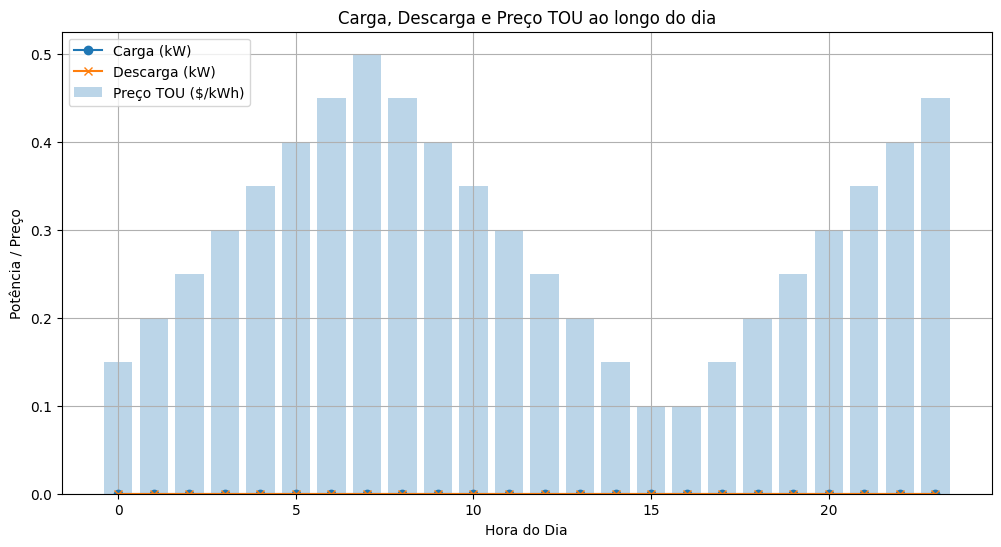

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from pyomo.environ import *

# Definição do modelo
model = ConcreteModel()
model.T = RangeSet(0, 23) # 24 horas

# Parâmetros
battery_power_max = 5 # potência máxima da bateria (kW)
price_tou = {t: preco for t, preco in enumerate([0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.45, 0.40, 0.35, 0.30, 0.25, 0.20, 0.15, 0.10, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45])}

# Variáveis
model.E_ch = Var(model.T, domain=NonNegativeReals) # energia carregada
model.E_dis = Var(model.T, domain=NonNegativeReals) # energia descarregada

# Variáveis binárias para impedir carga e descarga simultâneas
model.y_ch  = Var(model.T, domain=Binary)
model.y_dis = Var(model.T, domain=Binary)

# Restrições para ligar variáveis contínuas às binárias
model.ChargeLogic = Constraint(model.T, rule=lambda m, t: m.E_ch[t] <= battery_power_max * m.y_ch[t])
model.DischargeLogic = Constraint(model.T, rule=lambda m, t: m.E_dis[t] <= battery_power_max * m.y_dis[t])
model.ExclusiveCharge = Constraint(model.T, rule=lambda m, t: m.y_ch[t] + m.y_dis[t] <= 1)

# Função objetivo: minimizar custo total considerando TOU
model.obj = Objective(expr=sum(price_tou[t] * model.E_ch[t] for t in model.T), sense=minimize)

# Solver
solver = SolverFactory('glpk')
result = solver.solve(model)

# Extrair resultados
hours = list(model.T)
charge = [value(model.E_ch[t]) for t in model.T]
discharge = [value(model.E_dis[t]) for t in model.T]

# Criar DataFrame para visualização
df = pd.DataFrame({'Hora': hours, 'Carga (kW)': charge, 'Descarga (kW)': discharge, 'Preço TOU ($/kWh)': [price_tou[t] for t in hours]})

print(df)

# Gráficos
plt.figure(figsize=(12,6))
plt.plot(df['Hora'], df['Carga (kW)'], label='Carga (kW)', marker='o')
plt.plot(df['Hora'], df['Descarga (kW)'], label='Descarga (kW)', marker='x')
plt.bar(df['Hora'], df['Preço TOU ($/kWh)'], alpha=0.3, label='Preço TOU ($/kWh)')
plt.xlabel('Hora do Dia')
plt.ylabel('Potência / Preço')
plt.title('Carga, Descarga e Preço TOU ao longo do dia')
plt.legend()
plt.grid(True)
plt.show()